# ===============================================================
# P7 - Implémentez un modèle de scoring
# ===============================================================

Date de création : 02/11/2021       Dates de modifications : 03/11/2021  - 04/11/2021

Créateur : Steven SON

Sources : Notebook Kaggle de Will Koehrsen
Notebook de Christopher Pellerito · copié de jaehyun park
Notebook Homecredit default risk model creation de Sang

In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import re
from os import listdir
# preprocessing steps
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# machine learning models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
path = '.'
 
files = os.listdir(path)
for name in files:
    print(name)

.ipynb_checkpoints
application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
Logo Société.png
P7_00_notebook.ipynb
P7_04_support.pptx
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [3]:
files = ['application_test.csv','application_train.csv','bureau.csv','bureau_balance.csv','credit_card_balance.csv',
         'HomeCredit_columns_description.csv','installments_payments.csv','POS_CASH_balance.csv','previous_application.csv',
         'sample_submission.csv']

In [4]:
files

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [5]:
len(files)

10

In [6]:
app_test =pd.read_csv(files[0])
app_train =pd.read_csv(files[1])
bureau =pd.read_csv(files[2])
bureauBalance =pd.read_csv(files[3])
creditcardBalance =pd.read_csv(files[4])

installments =pd.read_csv(files[6])
POScashBalance =pd.read_csv(files[7])
previous_app =pd.read_csv(files[8])
samplesubmit =pd.read_csv(files[9])

In [7]:
Homecredit =pd.read_csv(files[5], engine='python')

In [8]:
Homecredit.isnull().sum().sum()

133

## 1. Observons les données

In [9]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [11]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [12]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [13]:
# bureau - separate data set with history for each customer. Let's make a crosstable and then 
# left-join it into the training data.

print(bureau.shape)           # 27299925, 3
bureau.nunique()       # 817,395 unique customers, 8 unique statuses

(1716428, 17)


SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64

In [14]:
# credit card data. Let's get average balance by customer
print(creditcardBalance.shape)           # 3840312, 23
print(creditcardBalance.nunique())       
cc_table = creditcardBalance.groupby(['SK_ID_CURR']).agg(np.mean)['AMT_BALANCE'].to_frame()
cc_table.head()

(3840312, 23)
SK_ID_PREV                     104307
SK_ID_CURR                     103558
MONTHS_BALANCE                     96
AMT_BALANCE                   1347904
AMT_CREDIT_LIMIT_ACTUAL           181
AMT_DRAWINGS_ATM_CURRENT         2267
AMT_DRAWINGS_CURRENT           187005
AMT_DRAWINGS_OTHER_CURRENT       1832
AMT_DRAWINGS_POS_CURRENT       168748
AMT_INST_MIN_REGULARITY        312266
AMT_PAYMENT_CURRENT            163209
AMT_PAYMENT_TOTAL_CURRENT      182957
AMT_RECEIVABLE_PRINCIPAL      1195839
AMT_RECIVABLE                 1338878
AMT_TOTAL_RECEIVABLE          1339008
CNT_DRAWINGS_ATM_CURRENT           44
CNT_DRAWINGS_CURRENT              129
CNT_DRAWINGS_OTHER_CURRENT         11
CNT_DRAWINGS_POS_CURRENT          133
CNT_INSTALMENT_MATURE_CUM         121
NAME_CONTRACT_STATUS                7
SK_DPD                            917
SK_DPD_DEF                        378
dtype: int64


,AMT_BALANCE
SK_ID_CURR,
100006,0.000000
100011,54482.111149
100013,18159.919219
100021,0.000000
100023,0.000000


In [15]:
print('Shape of training data:', app_train.shape)
app_train.head(5)
# over 300,000 records in the training set, and 121 features (plus whatever other features we end up importing
# from the supplemental tables.) Target variable is "TARGET."

Shape of training data: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Proportion Table for target variable

In [16]:
# Proportion - about 91.9% are zero (not default) and 8.1% are one (default.)
# Project is being scored as AUC (area under curve) i.e. confidence matters. The best scores of all time are around 80-81%
# so you can't score high by making a model that naively guesses that everything is a no-default.
(app_train['TARGET'].value_counts() / len(app_train)).to_frame()

,TARGET
0,0.919271
1,0.080729


How many categorical variables do we have, and how many levels in each?

In [17]:
app_train.dtypes.value_counts()
# There are 16 categorical variables in our model.

float64    65
int64      41
object     16
dtype: int64

In [18]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).to_frame()
# These are the sixteen categorical variables: there would be >100 dummy variables in our model if we one-hot encoded all of these.

,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


Missing Data

In [19]:
app_train.isna().sum().to_frame().sort_values(0, ascending = False).head(10)
# Lots of variables have missing values. We need to come up with a strategy for imputing missing values.

,0
COMMONAREA_MEDI,214865
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
NONLIVINGAPARTMENTS_MEDI,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_MODE,210199
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199


Some Visualizations

In [20]:
# Let's create a sample of 1000 rows from the training data, so that these graphics can render in a reasonable amount of time.
train_1K = app_train.sample(n=1000, random_state=1)

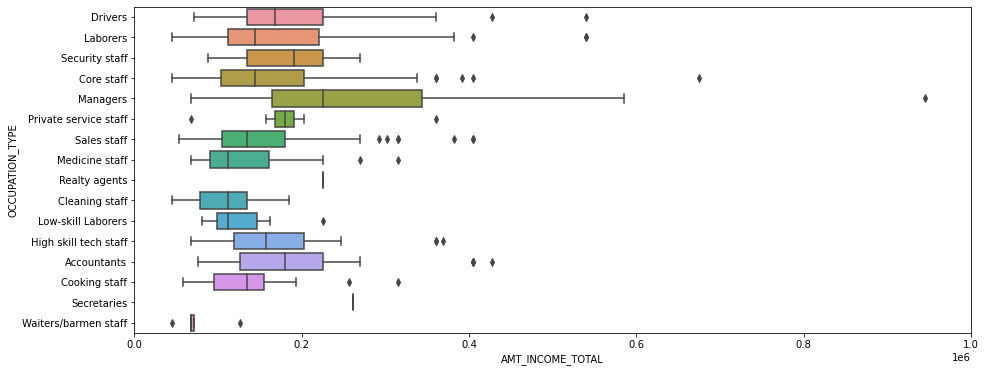

In [21]:
# Income by occupation type
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.boxplot(y = "OCCUPATION_TYPE", x = "AMT_INCOME_TOTAL", orient = "h", data = train_1K)
plt.xlim([0, 1e6])
plt.show()

I like two-sided violin plots for categorical classification problems. They can help you see whether different groups

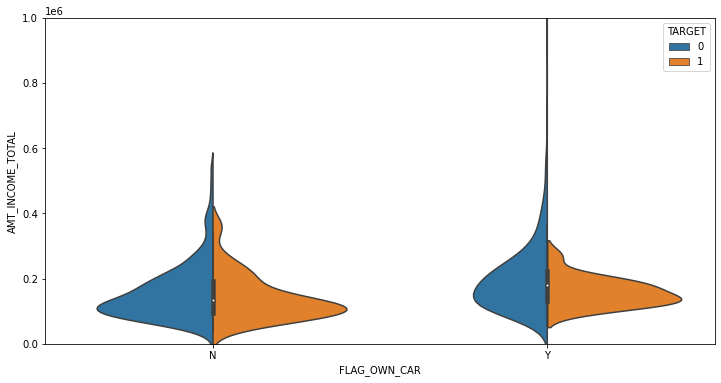

In [22]:
 # have different sensitivities.

fig, ax = plt.subplots(figsize=(12, 6))
plt.ylim([0, 1e6])
ax = sns.violinplot(x="FLAG_OWN_CAR", y="AMT_INCOME_TOTAL", hue = "TARGET", split = True, data=train_1K)
plt.show()

<Figure size 576x576 with 0 Axes>

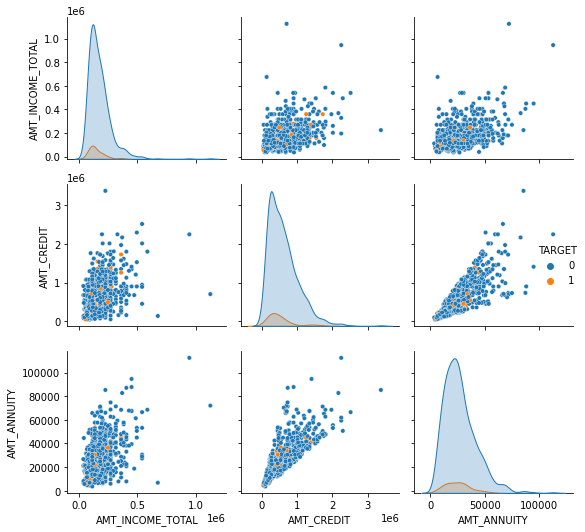

In [23]:
# Pairplot - I just picked a few continuous variables to show. Blue = 0 (not default), orange = 1 (default)
NumRows = train_1K.iloc[:,[1, 7,8,9]]
ax = plt.figure(figsize = (8, 8))
ax=sns.pairplot(NumRows, hue = "TARGET", plot_kws={'s':20})
plt.tight_layout()
plt.show()

Correlations

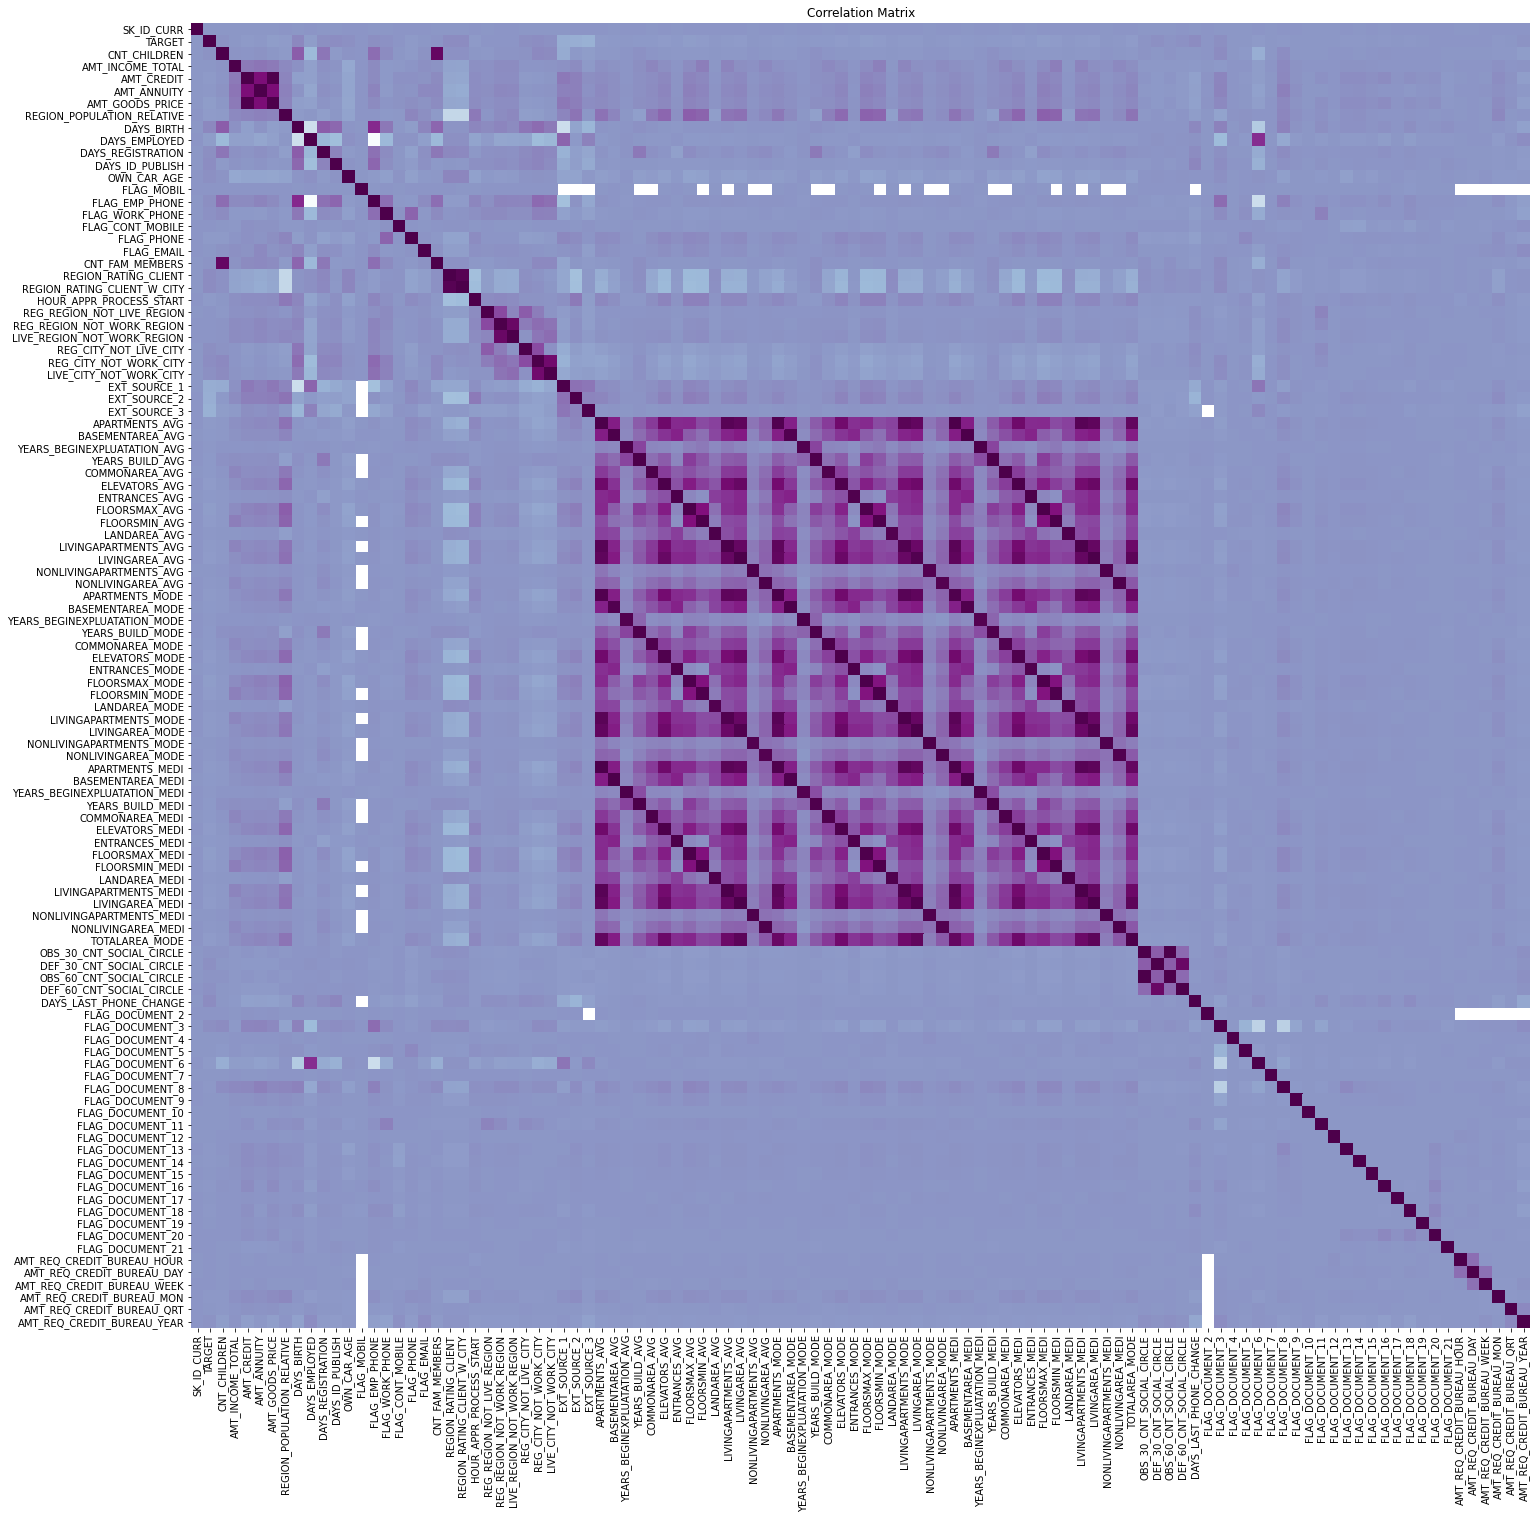

In [24]:
correl = app_train.corr()
fig, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(correl, annot = False, cmap = "BuPu", label = 'small', cbar = False)
ax.set_title('Correlation Matrix'); 
plt.show()

# Big ol' correlation matrix shows that there are some highly correlated variables. This data set could be
# a candidate for feature reduction using Principal Component Analysis.

Categorical association - Cramer's V

In [25]:
import scipy.stats as ss   # need this for chi-squared function

In [26]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

# Cramer's V (φ) is similar to Pearson's R (correlation coefficient) but it works with categorical data.
# While R has a range from -1 to +1, V has a range of 0 to +1. We are going to use this to build a
# heatmap that will help us evaluate whether the categorical variables are independent.

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

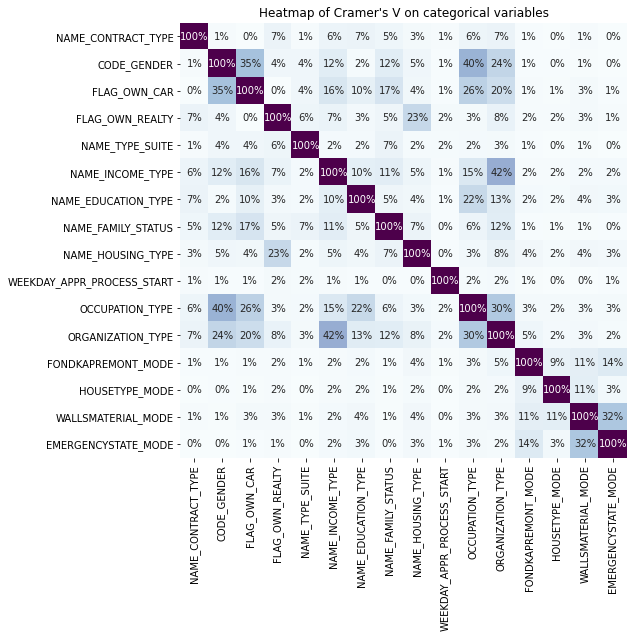

In [27]:
# I don't see a big opportunity for feature reduction here, but it was worth taking a look. And the heatmap looks cool.

CatFeatures = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', \
               'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', \
               'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

LL = len(CatFeatures)
cramers_outputs = []
for x in range(0,LL):
    first = app_train.loc[:,CatFeatures[x]]
    for y in range(0,LL):
        second = app_train.loc[:,CatFeatures[y]]
        result = round(cramers_v(first,second),4)
        cramers_outputs.append(result.tolist())
array = np.array(cramers_outputs)
reshaped = array.reshape(LL,LL)

fig = plt.figure(figsize = (8, 8))  # instanciate figure for heat map
ax = sns.heatmap(reshaped, annot = True,  cmap = "BuPu", fmt=".0%", cbar = False)
ax.set_xticklabels(CatFeatures)
ax.set_yticklabels(CatFeatures)
ax.tick_params(axis = 'x', labelrotation = 90)
ax.tick_params(axis = 'y', labelrotation = 0)
ax.set_title("Heatmap of Cramer's V on categorical variables");



In [28]:
app_test.isnull().sum().sum()

1404419

In [29]:
bureau.isnull().sum().sum()

3939947

In [30]:
bureauBalance.isnull().sum().sum()

0

In [31]:
POScashBalance.isnull().sum().sum()

52158

In [32]:
creditcardBalance.isnull().sum().sum()

5877356

In [33]:
previous_app.isnull().sum().sum()

11109336

In [34]:
installments.isnull().sum().sum()

5810

In [35]:
samplesubmit

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


In [36]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Création du modèle

In [37]:
#checking the memory usage and other information about data
print(app_train.info())
print('{Dimensions}')
print(app_train.shape)
print(app_test.info())
print('{Dimensions}')
print(app_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
{Dimensions}
(307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None
{Dimensions}
(48744, 121)


In [38]:
print("checking no. of columns in app_train with any null values: ", app_train.isnull().any().sum())
print("checking no. of columns in app_train with all null values: ", app_train.isnull().all().sum())
print("checking no. of rows in app_train with all null values: ", app_train.isnull().all(axis = 1).sum())
print("list of columns in app_train with null values: ", app_train.columns[app_train.isna().any()].tolist())

checking no. of columns in app_train with any null values:  67
checking no. of columns in app_train with all null values:  0
checking no. of rows in app_train with all null values:  0
list of columns in app_train with null values:  ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',

In [39]:
print("checking no. of columns in app_test with any null values: ",app_test.isnull().any().sum())
print("checking no. of columns in app_test with all null values: ", app_test.isnull().all().sum())
print("checking no. of rows in app_test with all null values: ", app_test.isnull().all(axis = 1).sum())
print("list of columns in app_test with null values: ", app_test.columns[app_test.isna().any()].tolist())

checking no. of columns in app_test with any null values:  64
checking no. of columns in app_test with all null values:  0
checking no. of rows in app_test with all null values:  0
list of columns in app_test with null values:  ['AMT_ANNUITY', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BU

In [40]:
# Traitement des valeurs négatives

app_train['DAYS_BIRTH'] = app_train['DAYS_BIRTH'].abs()
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].abs()
app_train['DAYS_REGISTRATION'] = app_train['DAYS_REGISTRATION'].abs()
app_train['DAYS_ID_PUBLISH'] = app_train['DAYS_ID_PUBLISH'].abs()
app_train['DAYS_LAST_PHONE_CHANGE'] = app_train['DAYS_LAST_PHONE_CHANGE'].abs()

In [41]:
app_test['DAYS_BIRTH'] = app_test['DAYS_BIRTH'].abs()
app_test['DAYS_EMPLOYED'] = app_test['DAYS_EMPLOYED'].abs()
app_test['DAYS_REGISTRATION'] = app_test['DAYS_REGISTRATION'].abs()
app_test['DAYS_ID_PUBLISH'] = app_test['DAYS_ID_PUBLISH'].abs()
app_test['DAYS_LAST_PHONE_CHANGE'] = app_test['DAYS_LAST_PHONE_CHANGE'].abs()

In [42]:
# checking the percentage of null values in the train_data columns having null values.
x=app_train.isnull().sum()
y=(app_train.isnull().sum()/app_train.shape[0])*100
z={'Number of missing values':x,'Percentage of missing values':y}
df=pd.DataFrame(z,columns=['Number of missing values','Percentage of missing values'])
df.sort_values(by='Percentage of missing values',ascending=False).head()

,Number of missing values,Percentage of missing values
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963


In [43]:
#checking the percentage of null values in the test_data columns having null values.
x=app_test.isnull().sum()
y=(app_test.isnull().sum()/app_test.shape[0])*100
z={'Number of missing values':x,'Percentage of missing values':y}
df_test=pd.DataFrame(z,columns=['Number of missing values','Percentage of missing values'])
df_test.sort_values(by='Percentage of missing values',ascending=False).head()

,Number of missing values,Percentage of missing values
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523


In [44]:
#assigning the null values of app_train to variables 
val= app_train.isnull().sum()
#taking the null values greater then 30%
drop_column = val[val.values >= 92253]
##checking the length columns having null values more then 30%
print(len(drop_column))
#checking the list of columns to be dropped
print(drop_column.index)

50
Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NO

In [45]:
#assigning the null values of test_data to variables 
val= app_test.isnull().sum()
#taking the null values greater then 30%
drop_column = val[val.values >= 14624]
##checking the length columns having null values more then 30%
print(len(drop_column))
#checking the list of columns to be dropped
print(drop_column.index)

50
Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NO

In [46]:
#Dropping the null values columns having more then 30% of missing values except "OCCUPATION_TYPE" in app_train.
app_train = app_train.drop(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE'] , axis = 1)

In [47]:
#Dropping the null values columns having more then 30% of missing values except "OCCUPATION_TYPE" in app_test.
app_test = app_test.drop(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE'] , axis = 1)

In [48]:
print('Dimensions de app_train =',app_train.shape)
print('Dimensions de app_test =',app_test.shape)

Dimensions de app_train = (307511, 73)
Dimensions de app_test = (48744, 72)


In [49]:
# Séparons les données numériques des données catégorielles
print(app_train.dtypes[app_train.isnull().any()])
print(len(app_train.dtypes[app_train.isnull().any()]))

AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
OCCUPATION_TYPE                object
CNT_FAM_MEMBERS               float64
EXT_SOURCE_2                  float64
EXT_SOURCE_3                  float64
OBS_30_CNT_SOCIAL_CIRCLE      float64
DEF_30_CNT_SOCIAL_CIRCLE      float64
OBS_60_CNT_SOCIAL_CIRCLE      float64
DEF_60_CNT_SOCIAL_CIRCLE      float64
DAYS_LAST_PHONE_CHANGE        float64
AMT_REQ_CREDIT_BUREAU_HOUR    float64
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
dtype: object
18


In [50]:
print(app_test.dtypes[app_test.isnull().any()])
print(len(app_test.dtypes[app_test.isnull().any()]))

AMT_ANNUITY                   float64
NAME_TYPE_SUITE                object
OCCUPATION_TYPE                object
EXT_SOURCE_2                  float64
EXT_SOURCE_3                  float64
OBS_30_CNT_SOCIAL_CIRCLE      float64
DEF_30_CNT_SOCIAL_CIRCLE      float64
OBS_60_CNT_SOCIAL_CIRCLE      float64
DEF_60_CNT_SOCIAL_CIRCLE      float64
AMT_REQ_CREDIT_BUREAU_HOUR    float64
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
dtype: object
15


In [51]:
# Data Parsing
train_categorical = app_train.select_dtypes(include = ['object'])
test_categorical = app_test.select_dtypes(include = ['object'])

In [52]:
train_categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [53]:
test_categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,NaN,TUESDAY,Kindergarten
1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Self-employed
2,Cash loans,M,Y,Y,NaN,Working,Higher education,Married,House / apartment,Drivers,MONDAY,Transport: type 3
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,FRIDAY,Business Entity Type 3


In [54]:
null_train = app_train[app_train.columns[app_train.isnull().any()]]
null_test = app_test[app_test.columns[app_test.isnull().any()]]

In [55]:
def value_count():
    for i in range(len(null_train.columns)):
        if len(null_train.iloc[:,i].value_counts()) <= 100:
            print(null_train.columns[[i]])
value_count()

Index(['NAME_TYPE_SUITE'], dtype='object')
Index(['OCCUPATION_TYPE'], dtype='object')
Index(['CNT_FAM_MEMBERS'], dtype='object')
Index(['OBS_30_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['DEF_30_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['DEF_60_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_HOUR'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_DAY'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_WEEK'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_MON'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_QRT'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_YEAR'], dtype='object')


In [56]:
def value_count():
    for i in range(len(null_test.columns)):
        if len(null_test.iloc[:,i].value_counts()) <= 100:
            print(null_test.columns[[i]])
value_count()

Index(['NAME_TYPE_SUITE'], dtype='object')
Index(['OCCUPATION_TYPE'], dtype='object')
Index(['OBS_30_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['DEF_30_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['DEF_60_CNT_SOCIAL_CIRCLE'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_HOUR'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_DAY'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_WEEK'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_MON'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_QRT'], dtype='object')
Index(['AMT_REQ_CREDIT_BUREAU_YEAR'], dtype='object')


In [57]:
# Fill numeric null values
print(app_train['AMT_ANNUITY'].describe())
print('\n')
print(app_test['AMT_ANNUITY'].describe())

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64


count     48720.000000
mean      29426.240209
std       16016.368315
min        2295.000000
25%       17973.000000
50%       26199.000000
75%       37390.500000
max      180576.000000
Name: AMT_ANNUITY, dtype: float64


(array([1.78916e+05, 1.12480e+05, 1.44110e+04, 1.26800e+03, 3.02000e+02,
       6.10000e+01, 2.20000e+01, 5.00000e+00, 3.30000e+01, 1.00000e+00]), array([  1615.5,  27256.5,  52897.5,  78538.5, 104179.5, 129820.5,
       155461.5, 181102.5, 206743.5, 232384.5, 258025.5]), <BarContainer object of 10 artists>)
(array([1.5019e+04, 2.1904e+04, 8.4840e+03, 2.6200e+03, 4.3100e+02,
       1.9100e+02, 2.6000e+01, 2.5000e+01, 1.0000e+00, 1.9000e+01]), array([  2295. ,  20123.1,  37951.2,  55779.3,  73607.4,  91435.5,
       109263.6, 127091.7, 144919.8, 162747.9, 180576. ]), <BarContainer object of 10 artists>)


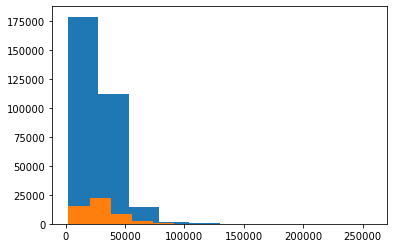

In [58]:
print(plt.hist(app_train['AMT_ANNUITY']))
print(plt.hist(app_test['AMT_ANNUITY']))

In [59]:
# On remplace ici les valeurs nulles par la médiane 
app_train['AMT_ANNUITY'] = app_train['AMT_ANNUITY'].fillna(app_train['AMT_ANNUITY'].median())
app_test['AMT_ANNUITY'] = app_test['AMT_ANNUITY'].fillna(app_test['AMT_ANNUITY'].median())

In [60]:
# Vérification
print(app_train['AMT_GOODS_PRICE'].describe())
app_test['AMT_GOODS_PRICE'].describe()

count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64


count    4.874400e+04
mean     4.626188e+05
std      3.367102e+05
min      4.500000e+04
25%      2.250000e+05
50%      3.960000e+05
75%      6.300000e+05
max      2.245500e+06
Name: AMT_GOODS_PRICE, dtype: float64

(array([1.31712e+05, 1.15261e+05, 4.36580e+04, 1.24290e+04, 3.17500e+03,
        9.33000e+02, 3.00000e+01, 1.70000e+01, 8.00000e+00, 1.00000e+01]),
 array([  40500.,  441450.,  842400., 1243350., 1644300., 2045250.,
        2446200., 2847150., 3248100., 3649050., 4050000.]),
 <BarContainer object of 10 artists>)

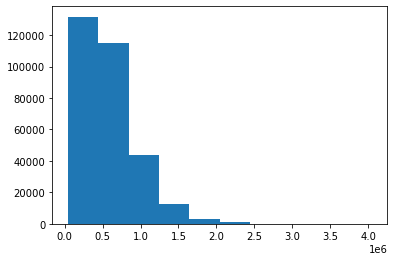

In [61]:
plt.hist(app_train['AMT_GOODS_PRICE'])

In [62]:
app_train['AMT_GOODS_PRICE'].value_counts().head()

450000.0    26022
225000.0    25282
675000.0    24962
900000.0    15416
270000.0    11428
Name: AMT_GOODS_PRICE, dtype: int64

In [63]:
print("median: ",app_train['AMT_GOODS_PRICE'].median())
print("mode: ",app_train['AMT_GOODS_PRICE'].mode()[0])
print("mean: ",app_train['AMT_GOODS_PRICE'].mean())

median:  450000.0
mode:  450000.0
mean:  538396.2074288895


In [64]:
app_train['AMT_GOODS_PRICE'] = app_train['AMT_GOODS_PRICE'].fillna(app_train['AMT_GOODS_PRICE'].median())

In [65]:
app_train['DAYS_LAST_PHONE_CHANGE'].describe()

count    307510.000000
mean        962.858788
std         826.808487
min           0.000000
25%         274.000000
50%         757.000000
75%        1570.000000
max        4292.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [66]:
app_train['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

0.0    37672
1.0     2812
2.0     2318
3.0     1763
4.0     1285
Name: DAYS_LAST_PHONE_CHANGE, dtype: int64

(array([1.03256e+05, 6.25090e+04, 3.86590e+04, 4.12270e+04, 3.05080e+04,
        1.79930e+04, 8.65400e+03, 4.01700e+03, 6.29000e+02, 5.80000e+01]),
 array([   0. ,  429.2,  858.4, 1287.6, 1716.8, 2146. , 2575.2, 3004.4,
        3433.6, 3862.8, 4292. ]),
 <BarContainer object of 10 artists>)

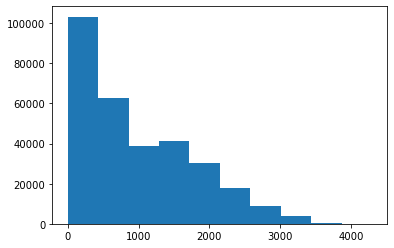

In [67]:
plt.hist(app_train['DAYS_LAST_PHONE_CHANGE'])

In [68]:
print(app_train['DAYS_LAST_PHONE_CHANGE'].mode()[0])
print(app_train['DAYS_LAST_PHONE_CHANGE'].median())

0.0
757.0


In [69]:
app_train['DAYS_LAST_PHONE_CHANGE'] = app_train['DAYS_LAST_PHONE_CHANGE'].fillna(app_train['DAYS_LAST_PHONE_CHANGE'].median())

In [70]:
app_train['EXT_SOURCE_2'].describe()

count    3.068510e+05
mean     5.143927e-01
std      1.910602e-01
min      8.173617e-08
25%      3.924574e-01
50%      5.659614e-01
75%      6.636171e-01
max      8.549997e-01
Name: EXT_SOURCE_2, dtype: float64

In [71]:
app_train['EXT_SOURCE_2'].value_counts().head()

0.285898    721
0.262258    417
0.265256    343
0.159679    322
0.265312    306
Name: EXT_SOURCE_2, dtype: int64

In [72]:
print(app_train['EXT_SOURCE_2'].mean())
print(app_train['EXT_SOURCE_2'].median())
print(app_train['EXT_SOURCE_2'].mode()[0])
print(app_test['EXT_SOURCE_2'].mean())
print(app_test['EXT_SOURCE_2'].median())
print(app_test['EXT_SOURCE_2'].mode()[0])

0.5143926741308463
0.5659614260608526
0.2858978721410488
0.518021075670542
0.5587579430597367
0.2858978721410488


(array([ 1165.,  1629.,  2640.,  3370.,  4521.,  6430.,  9168., 10909.,
         7768.,  1136.]),
 array([8.09785588e-06, 8.55072547e-02, 1.71006412e-01, 2.56505568e-01,
        3.42004725e-01, 4.27503882e-01, 5.13003039e-01, 5.98502196e-01,
        6.84001353e-01, 7.69500510e-01, 8.54999666e-01]),
 <BarContainer object of 10 artists>)

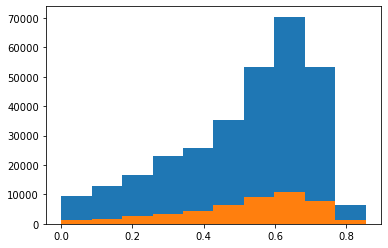

In [73]:
plt.hist(app_train['EXT_SOURCE_2'])
plt.hist(app_test['EXT_SOURCE_2'])

In [74]:
app_train['EXT_SOURCE_2'] = app_train['EXT_SOURCE_2'].fillna(app_train['EXT_SOURCE_2'].median())
app_test['EXT_SOURCE_2'] = app_test['EXT_SOURCE_2'].fillna(app_test['EXT_SOURCE_2'].median())

In [75]:
print(app_train['EXT_SOURCE_3'].describe())
print('\n')
print(app_test['EXT_SOURCE_3'].describe())

count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64


count    40076.000000
mean         0.500106
std          0.189498
min          0.000527
25%          0.363945
50%          0.519097
75%          0.652897
max          0.882530
Name: EXT_SOURCE_3, dtype: float64


In [76]:
print(app_train['EXT_SOURCE_3'].median())
print(app_train['EXT_SOURCE_3'].mean())
print(app_train['EXT_SOURCE_3'].mode())
print(app_test['EXT_SOURCE_3'].median())
print(app_test['EXT_SOURCE_3'].mean())
print(app_test['EXT_SOURCE_3'].mode())

0.5352762504724826
0.5108529061800121
0    0.7463
dtype: float64
0.5190973382084597
0.5001056254095644
0    0.706205
dtype: float64


(array([ 525., 1928., 3105., 3886., 5240., 6066., 6643., 6395., 4975.,
        1313.]),
 array([5.27265239e-04, 8.87275700e-02, 1.76927875e-01, 2.65128180e-01,
        3.53328484e-01, 4.41528789e-01, 5.29729094e-01, 6.17929399e-01,
        7.06129703e-01, 7.94330008e-01, 8.82530313e-01]),
 <BarContainer object of 10 artists>)

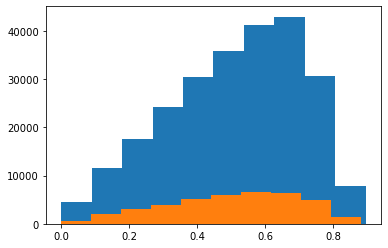

In [77]:
plt.hist(app_train['EXT_SOURCE_3'])
plt.hist(app_test['EXT_SOURCE_3'])

In [78]:
app_train['EXT_SOURCE_3'] = app_train['EXT_SOURCE_3'].fillna(app_train['EXT_SOURCE_3'].median())
app_test['EXT_SOURCE_3'] = app_test['EXT_SOURCE_3'].fillna(app_test['EXT_SOURCE_3'].median())

Filling Categorical null values using function

In [79]:
def filling_TrainDataCategoricalNullvalues(train_data):
    for i in range(len(null_train.columns)):
        if len(null_train.iloc[:,i].value_counts()) <= 100:
            column = null_train.columns[i]
            train_data[column] = train_data[column].fillna(train_data[column].mode()[0])
filling_TrainDataCategoricalNullvalues(app_train)

In [80]:
def filling_TestDataCategoricalNullvalues(test_data):
    for i in range(len(null_test.columns)):
        if len(null_test.iloc[:,i].value_counts()) <= 100:
            column = null_test.columns[i]
            test_data[column] = test_data[column].fillna(test_data[column].mode()[0])
filling_TestDataCategoricalNullvalues(app_test)

In [81]:
print(app_train.isnull().sum().sum())
print(app_test.isnull().sum().sum())

0
0


Checking of duplicate rows and columns

In [82]:
train_duplicate = app_train[app_train.duplicated()]
test_duplicate = app_test[app_test.duplicated()]
train_duplicate.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [83]:
test_duplicate.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [84]:
#checking for duplicate columns
def getDuplicateColumns(df):
  
    # Create an empty set
    duplicateColumnNames = set()
      
    # Iterate through all the columns 
    # of dataframe
    for x in range(df.shape[1]):
          
        # Take column at xth index.
        col = df.iloc[:, x]
          
        # Iterate through all the columns in
        # DataFrame from (x + 1)th index to
        # last index
        for y in range(x + 1, df.shape[1]):
              
            # Take column at yth index.
            otherCol = df.iloc[:, y]
              
            # Check if two columns at x & y
            # index are equal or not,
            # if equal then adding 
            # to the set
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
                  
    # Return list of unique column names 
    # whose contents are duplicates.
    return list(duplicateColumnNames)
getDuplicateColumns(app_train)

[]

In [85]:
getDuplicateColumns(app_test)

['FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17']

Encoding categorical values
For categorical data we perform three kinds of encoding . Ordinal enconding , OneHot encoding. These encodings performed looking into the data types. lets say we have a categorical data which is related and having rank then we have to perform ordinal encoding. If the categorical data is not displaying any rank order among it self then OneHot encoding can be used. While using OneHot encoding dummy variable trap is taken care.

In [86]:
def value_count():
    for i in range(len(train_categorical.columns)):
        print(train_categorical.columns[[i]])
        print(len(train_categorical.iloc[:,i].value_counts()))
        print('\n')
            
value_count()

Index(['NAME_CONTRACT_TYPE'], dtype='object')
2


Index(['CODE_GENDER'], dtype='object')
3


Index(['FLAG_OWN_CAR'], dtype='object')
2


Index(['FLAG_OWN_REALTY'], dtype='object')
2


Index(['NAME_TYPE_SUITE'], dtype='object')
7


Index(['NAME_INCOME_TYPE'], dtype='object')
8


Index(['NAME_EDUCATION_TYPE'], dtype='object')
5


Index(['NAME_FAMILY_STATUS'], dtype='object')
6


Index(['NAME_HOUSING_TYPE'], dtype='object')
6


Index(['OCCUPATION_TYPE'], dtype='object')
18


Index(['WEEKDAY_APPR_PROCESS_START'], dtype='object')
7


Index(['ORGANIZATION_TYPE'], dtype='object')
58




In [87]:
def value_count():
    for i in range(len(test_categorical.columns)):
        print(test_categorical.columns[[i]])
        print(len(test_categorical.iloc[:,i].value_counts()))
        print('\n')
            
value_count()

Index(['NAME_CONTRACT_TYPE'], dtype='object')
2


Index(['CODE_GENDER'], dtype='object')
2


Index(['FLAG_OWN_CAR'], dtype='object')
2


Index(['FLAG_OWN_REALTY'], dtype='object')
2


Index(['NAME_TYPE_SUITE'], dtype='object')
7


Index(['NAME_INCOME_TYPE'], dtype='object')
7


Index(['NAME_EDUCATION_TYPE'], dtype='object')
5


Index(['NAME_FAMILY_STATUS'], dtype='object')
5


Index(['NAME_HOUSING_TYPE'], dtype='object')
6


Index(['OCCUPATION_TYPE'], dtype='object')
18


Index(['WEEKDAY_APPR_PROCESS_START'], dtype='object')
7


Index(['ORGANIZATION_TYPE'], dtype='object')
58




In [88]:
print(app_train['NAME_CONTRACT_TYPE'].unique())
CT = ['Cash loans', 'Revolving loans']

['Cash loans' 'Revolving loans']


In [89]:
print(app_train['CODE_GENDER'].unique())
print(app_test['CODE_GENDER'].unique())
train_CG = ['M', 'F' ,'XNA']
test_CG = ['M', 'F']

['M' 'F' 'XNA']
['F' 'M']


In [90]:
print(app_train['FLAG_OWN_CAR'].unique())
C = ['N', 'Y']

['N' 'Y']


In [91]:
print(app_train['FLAG_OWN_REALTY'].unique())
R = ['N', 'Y']

['Y' 'N']


In [92]:
app_train['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', 'Other_B', 'Group of people'], dtype=object)

In [93]:
print(app_train['NAME_INCOME_TYPE'].unique())
print(app_test['NAME_INCOME_TYPE'].unique())
train_IT = ['Unemployed', 'Student', 'Pensioner','Working','Commercial associate','State servant','Businessman','Maternity leave' ]
test_IT = ['Unemployed', 'Student', 'Pensioner','Working','Commercial associate','State servant','Businessman' ]

['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
['Working' 'State servant' 'Pensioner' 'Commercial associate'
 'Businessman' 'Student' 'Unemployed']


In [94]:
print(app_train['NAME_EDUCATION_TYPE'].unique())
ET = ['Lower secondary','Secondary / secondary special','Incomplete higher','Higher education','Academic degree']

['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


In [95]:
print(app_train['NAME_FAMILY_STATUS'].unique())
print(app_test['NAME_FAMILY_STATUS'].unique())
train_FS = ['Widow','Separated','Single / not married','Married','Civil marriage','Unknown',]
test_FS = ['Widow','Separated','Single / not married','Married','Civil marriage']

['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']


In [96]:
app_train['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [97]:
app_train['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Drivers',
       'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [98]:
app_train['WEEKDAY_APPR_PROCESS_START'].unique()

array(['WEDNESDAY', 'MONDAY', 'THURSDAY', 'SUNDAY', 'SATURDAY', 'FRIDAY',
       'TUESDAY'], dtype=object)

In [99]:
app_train['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

In [100]:
from sklearn.preprocessing import OrdinalEncoder

In [101]:
OE_train = OrdinalEncoder(categories = [CT,train_CG, C, R, train_IT, ET, train_FS ])

In [102]:
OE_train.fit(app_train[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',\
                         'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']])

OrdinalEncoder(categories=[['Cash loans', 'Revolving loans'], ['M', 'F', 'XNA'],
                           ['N', 'Y'], ['N', 'Y'],
                           ['Unemployed', 'Student', 'Pensioner', 'Working',
                            'Commercial associate', 'State servant',
                            'Businessman', 'Maternity leave'],
                           ['Lower secondary', 'Secondary / secondary special',
                            'Incomplete higher', 'Higher education',
                            'Academic degree'],
                           ['Widow', 'Separated', 'Single / not married',
                            'Married', 'Civil marriage', 'Unknown']])

In [103]:
app_train[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE',\
            'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']] =\
OE_train.transform(app_train[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',\
                              'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']])

In [104]:
OE_test = OrdinalEncoder(categories = [CT,test_CG, C, R, test_IT, ET, test_FS ])

In [105]:
OE_test.fit(app_test[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',\
                         'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']])

OrdinalEncoder(categories=[['Cash loans', 'Revolving loans'], ['M', 'F'],
                           ['N', 'Y'], ['N', 'Y'],
                           ['Unemployed', 'Student', 'Pensioner', 'Working',
                            'Commercial associate', 'State servant',
                            'Businessman'],
                           ['Lower secondary', 'Secondary / secondary special',
                            'Incomplete higher', 'Higher education',
                            'Academic degree'],
                           ['Widow', 'Separated', 'Single / not married',
                            'Married', 'Civil marriage']])

In [106]:
app_test[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',\
                         'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']] =\
OE_test.transform(app_test[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',\
                         'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']])

In [107]:
app_test[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',\
                         'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
0,0.0,1.0,0.0,1.0,3.0,3.0,3.0
1,0.0,0.0,0.0,1.0,3.0,1.0,3.0
2,0.0,0.0,1.0,1.0,3.0,3.0,3.0
3,0.0,1.0,0.0,1.0,3.0,1.0,3.0
4,0.0,0.0,1.0,0.0,3.0,1.0,3.0


In [108]:
app_train[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',\
                         'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
0,0.0,0.0,0.0,1.0,3.0,1.0,2.0
1,0.0,1.0,0.0,0.0,5.0,3.0,3.0
2,1.0,0.0,1.0,1.0,3.0,1.0,2.0
3,0.0,1.0,0.0,1.0,3.0,1.0,4.0
4,0.0,0.0,0.0,1.0,3.0,1.0,2.0


In [109]:
print('Dimensions de app_train =',app_train.shape)
print('Dimensions de app_test = ',app_test.shape)

Dimensions de app_train = (307511, 73)
Dimensions de app_test =  (48744, 72)


In [110]:
#Applying one hot encoding.
app_train = pd.get_dummies(app_train , drop_first = True)
app_test = pd.get_dummies(app_test , drop_first = True)

In [111]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0.0,0.0,0.0,1.0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0.0,1.0,0.0,0.0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1.0,0.0,1.0,1.0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0.0,1.0,0.0,1.0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0.0,0.0,0.0,1.0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


In [112]:
y=app_train['TARGET']

<AxesSubplot:>

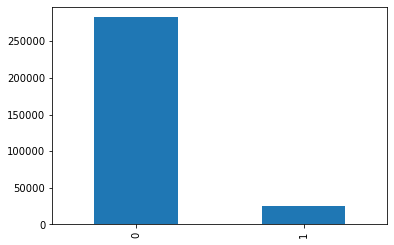

In [113]:
y.value_counts().plot.bar()

Splitting our dataset

In [114]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(app_train.drop(['TARGET'], axis = 1),\
                                            app_train['TARGET'],test_size = 0.2,random_state = 42)

In [115]:
x_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
123473,243191,0.0,1.0,1.0,0.0,0,171000.0,555273.0,16366.5,463500.0,...,0,0,0,0,0,0,0,0,0,1
10118,111778,0.0,0.0,0.0,1.0,1,157500.0,198085.5,23638.5,171000.0,...,0,0,0,0,0,0,0,0,0,0
64716,175057,0.0,0.0,1.0,1.0,0,135000.0,776304.0,25173.0,648000.0,...,0,0,0,0,0,0,0,0,0,0
234940,372147,0.0,0.0,1.0,1.0,1,164133.0,900000.0,36787.5,900000.0,...,0,0,0,0,0,0,0,0,0,0
236051,373412,0.0,0.0,0.0,1.0,0,225000.0,533668.5,21294.0,477000.0,...,0,0,0,0,0,0,0,0,0,0


Balancing Training Data

In [116]:
import imblearn

In [117]:
from imblearn.over_sampling import SMOTE

In [118]:
smote = SMOTE()

In [119]:
xtrain_smote , ytrain_smote = smote.fit_resample(x_train, y_train)

In [120]:
from collections import Counter

In [121]:
print("Before somte: " , Counter(y_train))
print("After smote: ", Counter(ytrain_smote))

Before somte:  Counter({0: 226132, 1: 19876})
After smote:  Counter({0: 226132, 1: 226132})


Applying Feature Scaling

In [122]:
from sklearn.preprocessing import StandardScaler

In [123]:
sc = StandardScaler()
xtrain_smote1 = pd.DataFrame(sc.fit_transform(xtrain_smote))
xtrain_smote1.columns = xtrain_smote.columns.values
xtrain_smote1.index = xtrain_smote.index.values
xtrain_smote = xtrain_smote1
xtrain_smote.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,-0.339264,-0.307641,0.848649,1.557930,-1.619331,-0.520774,0.064260,-0.066371,-0.782415,-0.152485,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,2.350261
1,-1.624230,-0.307641,-1.378699,-0.743969,0.727126,1.052050,-0.076945,-1.008869,-0.235866,-0.999199,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
2,-1.005483,-0.307641,-1.378699,1.557930,0.727126,-0.520774,-0.312287,0.516856,-0.120537,0.381596,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
3,0.921677,-0.307641,-1.378699,1.557930,0.727126,1.052050,-0.007566,0.843248,0.752385,1.111073,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
4,0.934046,-0.307641,-1.378699,-0.743969,0.727126,-0.520774,0.629080,-0.123378,-0.412074,-0.113406,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485


In [124]:
x_test1 = pd.DataFrame(sc.transform(x_test))
x_test1.columns = x_test.columns.values
x_test1.index = x_test.index.values
x_test = x_test1
x_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
245895,1.043199,-0.307641,-1.378699,1.557930,-1.619331,2.624875,0.440807,-0.303364,1.943901,-0.282748,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
98194,-0.624598,-0.307641,0.848649,1.557930,0.727126,-0.520774,0.864422,1.850459,1.666230,1.918708,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
36463,-1.326449,-0.307641,0.848649,1.557930,-1.619331,-0.520774,0.393738,-0.225411,0.926901,-0.061300,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
249923,1.088139,-0.307641,0.848649,-0.743969,0.727126,-0.520774,0.864422,-0.859482,-0.138124,-0.842882,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
158389,0.056024,-0.307641,-1.378699,-0.743969,0.727126,-0.520774,-0.547628,-0.718490,-0.820294,-0.816830,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485


In [125]:
test_data1 = pd.DataFrame(sc.transform(app_test))
test_data1.columns = app_test.columns.values
test_data1.index = app_test.index.values
test_data = test_data1
test_data1.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,-1.739387,-0.307641,0.848649,-0.743969,0.727126,-0.520774,-0.312287,-0.030678,-0.467203,-0.191564,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
1,-1.739347,-0.307641,-1.378699,-0.743969,0.727126,-0.520774,-0.688833,-0.943740,-0.706994,-0.973146,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
2,-1.739269,-0.307641,-1.378699,1.557930,0.727126,-0.520774,0.393738,0.218581,3.231806,0.329491,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,21.382724,-0.099731,-0.048675,-0.425485
3,-1.739123,-0.307641,0.848649,-0.743969,0.727126,2.624875,1.570447,2.624346,1.671641,3.065028,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485
4,-1.739025,-0.307641,-1.378699,1.557930,-1.619331,1.052050,0.158397,0.118935,0.397602,0.316464,...,-0.010409,-0.009522,-0.033501,-0.12015,-0.018215,-0.062611,-0.046767,-0.099731,-0.048675,-0.425485


Model Bulding

In [126]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
lr_c = LogisticRegression()
lr_c.fit(xtrain_smote, ytrain_smote)
y_prd = lr_c.predict(x_test)

#evaluating results
from sklearn.metrics import confusion_matrix , accuracy_score, f1_score,\
precision_score, recall_score


In [129]:
cm = confusion_matrix(y_test, y_prd)
cm

array([[55028,  1526],
       [ 4604,   345]], dtype=int64)

In [130]:
print(accuracy_score(y_test, y_prd))

0.9003300652000715


In [131]:
print(f1_score(y_test, y_prd))
print(precision_score(y_test, y_prd))
print(recall_score(y_test, y_prd))

0.10117302052785923
0.18439337252805987
0.06971105273792685


test_data accuracy: 0.9003


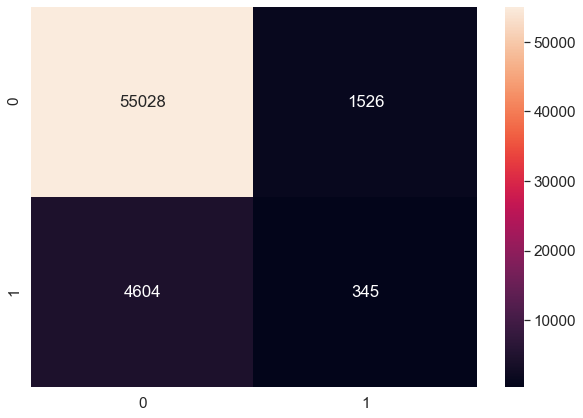

In [132]:
df_cm = pd.DataFrame(cm , index = (0,1), columns = (0,1))
plt.figure(figsize=(10,7))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm , annot = True , fmt = 'g')
print("test_data accuracy: %0.4f" % accuracy_score(y_test , y_prd))

Applying K_Fold cross validation

In [133]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = lr_c , 
                             X = xtrain_smote, 
                             y = ytrain_smote,
                             cv = 3)
accuracies

array([0.85489702, 0.96887665, 0.96917495])

In [134]:
accuracies.mean()

0.9309828732600295

## Feature selection
Information gain - mutual information in classification

In [138]:
from sklearn.feature_selection import mutual_info_classif


#checking the memory usage and other information about data
print(xtrain_smote.info())
print(xtrain_smote.dtypes.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452264 entries, 0 to 452263
Columns: 158 entries, SK_ID_CURR to ORGANIZATION_TYPE_XNA
dtypes: float64(158)
memory usage: 548.6 MB
None
[dtype('float64')]


In [139]:
%%time
mutual_info = mutual_info_classif(xtrain_smote , ytrain_smote)

Wall time: 9min 17s


In [140]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = xtrain_smote.columns
mutual_info.sort_values(ascending = False).head()

REGION_POPULATION_RELATIVE    0.511698
EXT_SOURCE_3                  0.493512
DAYS_LAST_PHONE_CHANGE        0.483254
DAYS_REGISTRATION             0.425898
AMT_ANNUITY                   0.384417
dtype: float64

In [141]:
from sklearn.feature_selection import SelectKBest

In [142]:
select_hundred_columns = SelectKBest(mutual_info_classif, k = 100)

In [143]:
%%time
select_hundred_columns.fit(xtrain_smote, ytrain_smote)

Wall time: 8min 46s


SelectKBest(k=100,
            score_func=<function mutual_info_classif at 0x0000021D80FBA8B0>)

In [144]:
xtrain_smote[xtrain_smote.columns[select_hundred_columns.get_support()]].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_XNA
0,-0.306871,0.849768,1.555477,-1.616936,-0.519600,0.065442,-0.064908,-0.781710,-0.151090,-1.622937,...,-0.064349,-0.061751,-0.127701,-0.076187,-0.297691,-0.079395,-0.120311,-0.062611,-0.0993,2.352707
1,-0.306871,-1.376598,-0.745588,0.728479,1.053586,-0.076170,-1.008933,-0.235069,-0.999069,-0.266437,...,-0.064349,-0.061751,-0.127701,-0.076187,-0.297691,-0.079395,-0.120311,-0.062611,-0.0993,-0.425042
2,-0.306871,-1.376598,1.555477,0.728479,-0.519600,-0.312190,0.519263,-0.119719,0.383789,-0.266437,...,-0.064349,-0.061751,-0.127701,-0.076187,3.359183,-0.079395,-0.120311,-0.062611,-0.0993,-0.425042
3,-0.306871,-1.376598,1.555477,0.728479,1.053586,-0.006592,0.846184,0.753351,1.114356,1.090062,...,-0.064349,-0.061751,-0.127701,-0.076187,-0.297691,12.595292,-0.120311,-0.062611,-0.0993,-0.425042
4,-0.306871,-1.376598,-0.745588,0.728479,-0.519600,0.631890,-0.122007,-0.411307,-0.111952,1.090062,...,-0.064349,-0.061751,-0.127701,-0.076187,-0.297691,-0.079395,-0.120311,-0.062611,-0.0993,-0.425042


In [145]:
%%time
lr_c.fit(xtrain_smote[xtrain_smote.columns[select_hundred_columns.get_support()]],ytrain_smote)

Wall time: 8.78 s


LogisticRegression()

In [146]:
y_prediction2 = lr_c.predict(x_test[x_test.columns[select_hundred_columns.get_support()]])

In [147]:
accuracy_score(y_prediction2,y_test)

0.8814204185161699

Hyperparameter optimization
Using GridSearchCv

In [148]:
params = lr_c.get_params()
params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [149]:
param_grid = [    
    {'penalty' : ['l1', 'l2'],
    'C' : [1,2],
    'solver' : ['lbfgs','liblinear'],
    'max_iter' : [100,200]
    }
]

In [150]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(lr_c, param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)

UsageError: Line magic function `%%time` not found.


In [ ]:
%%time
best_clf = clf.fit(xtrain_smote[xtrain_smote.columns[select_hundred_columns.get_support()]],ytrain_smote)
best_clf.best_estimator_

Bulding our model with best parameter values

In [ ]:
classification = LogisticRegression(C=1)

In [ ]:
classification.fit(xtrain_smote[xtrain_smote.columns[select_hundred_columns.get_support()]],ytrain_smote)

In [ ]:
prd = classification.predict(x_test[x_test.columns[select_hundred_columns.get_support()]])

In [ ]:
accuracy_score(prd, y_test)

Applying our test data values on the final model.

In [ ]:
testprd = classification.predict(test_data[test_data.columns[select_hundred_columns.get_support()]])

In [ ]:
test_prd = pd.DataFrame(testprd)

In [ ]:
test_prd.value_counts()